In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

In [0]:
class NetBatchNorm(nn.Module):
    
     def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
         super(NetBatchNorm, self).__init__()
         self.linear1 = nn.Linear(in_size, n_hidden1)
         self.linear2 = nn.Linear(n_hidden1, n_hidden2)
         self.linear3 = nn.Linear(n_hidden2, out_size)
         self.bn1 = nn.BatchNorm1d(n_hidden1)
         self.bn2 = nn.BatchNorm1d(n_hidden2)

     def forward(self, x):
         x = self.bn1(torch.sigmoid(self.linear1(x)))
         x = self.bn2(torch.sigmoid(self.linear2(x)))
         x = self.linear3(x)
         return x

     def activation(self, x):
         out = []
         z1 = self.bn1(self.linear1(x))
         out.append(z1.detach().numpy().reshape(-1))
         a1 = torch.sigmoid(z1)
         out.append(a1.detach().numpy().reshape(-1).reshape(-1))
         z2 = self.bn2(self.linear2(a1))
         out.append(z2.detach().numpy().reshape(-1))
         a2 = torch.sigmoid(z2)
         out.append(a2.detach().numpy().reshape(-1))
         return out        

In [0]:
class Net(nn.Module):
    
     def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
         super(Net, self).__init__()
         self.linear1 = nn.Linear(in_size, n_hidden1)
         self.linear2 = nn.Linear(n_hidden1, n_hidden2)
         self.linear3 = nn.Linear(n_hidden2, out_size)


     def forward(self, x):
         x = torch.sigmoid(self.linear1(x))
         x = torch.sigmoid(self.linear2(x))
         x = self.linear3(x)
         return x

     def activation(self, x):
         out = []
         z1 = self.linear1(x)
         out.append(z1.detach().numpy().reshape(-1))
         a1 = torch.sigmoid(z1)
         out.append(a1.detach().numpy().reshape(-1).reshape(-1))
         z2 = self.linear2(a1)
         out.append(z2.detach().numpy().reshape(-1))
         a2 = torch.sigmoid(z2)
         out.append(a2.detach().numpy().reshape(-1))
         return out        

In [0]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28*28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())

        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28*28))
            _, label = torch.max(yhat, 1)
            correct += (label== y).sum().item()
        
        accuracy = 100 * (correct/ len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff
    

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform = transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=5000, shuffle=False)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
input_dim = 28 *28 
hidden_dim = 100
output_dim = 10

In [0]:
model_norm = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm = train(model_norm, criterion, train_loader, validation_loader, optimizer, epochs=5)

In [0]:
model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

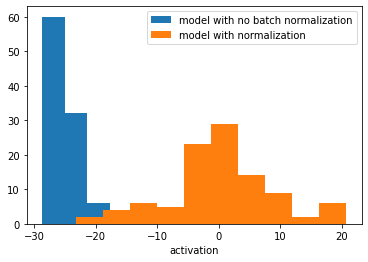

In [30]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2], label='model with no batch normalization')
out_norm = model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2], label='model with normalization')
plt.xlabel("activation")
plt.legend()
plt.show()

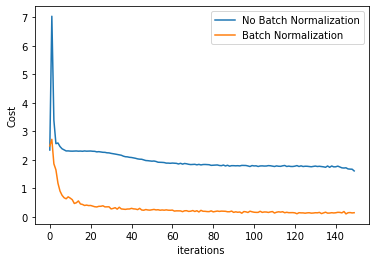

In [31]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

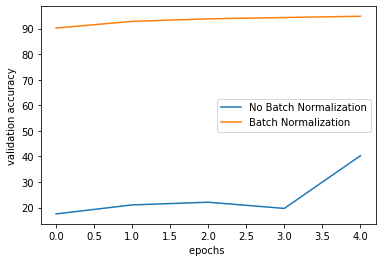

In [32]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()